In [189]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
from sklearn import linear_model

import SIRD_Model

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,header.index("Dates")]
    infected = infectionData[:,header.index("Infected")]
    recovered = infectionData[:,header.index("Recovered")]
    deaths = infectionData[:,header.index("Deaths")]
    vacc = infectionData[:,header.index("Vaccinated")]
    vacc = vacc.astype(float)
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    infected = infected.astype(float)
    return dates, infected, recovered, deaths, vacc

def showCurves(infected, recovered, dead, vacc, pop, q, graph=True):
    #since S+I+R+D always equals the same constant S(t) can now be determined
    suscept = q*pop - infected - vacc*q - recovered - dead
    
    nextIterMatrix, sirdMatrix = getSIRDVMatrices(suscept, infected, recovered, dead, vacc, pop)
    
    paramMatrix = np.zeros((len(sirdMatrix), 4)) #setup param (time dependent) matrix
    for t in range(len(sirdMatrix)): #solve each parameter list for every t
        paramMatrix[t] = np.linalg.lstsq(sirdMatrix[t], nextIterMatrix[t], rcond=None)[0].flatten() #solve for beta, gamma, upsilon
    
    transRate = paramMatrix[:,0] #beta
    recovRate = paramMatrix[:,1] #Gamma 
    deathRate = paramMatrix[:,2] #New
    vaccRate = paramMatrix[:,3] #Psi
    
    if(graph):

        #plot rates over time
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
        ax.plot(vacc, color = 'green', label = 'vaccinated')
        #ax.plot(asym, color = 'yellow', label = 'asymptomatic')
        ax.plot(infected, color='red', label='infected')
        ax.plot(recovered, color='cyan', label='recovered')
        ax.plot(dead, color='black', label='dead')

        fig2, ax2 = plt.subplots(4, 1, figsize=(18,8))
        ax2[0].plot(transRate, color='orange', label='Transmission Rate')
        #ax2[1].plot(asymRate, color = 'red', label = 'Asymptomatic rate')
        ax2[1].plot(recovRate, color='green', label='Recovery Rate')
        ax2[2].plot(vaccRate,color = 'yellow', label = 'Vaccination Rate')
        ax2[3].plot(deathRate, color='black', label='Death Rate')
    
    return paramMatrix

def getSIRDVMatrices(suscept, infect, recov, dead, vacc, pop):
    sirdMatrix = np.zeros((len(recov) - 1, 4, 3))
    nextIterMatrix = np.zeros((len(recov) - 1, 4, 1)) #the S(t+1), I(t+1), ... matrix
    
  
    #populate the 4x4 matrix with parameters (see above note)
    sirdMatrix[:,0,0] = -((suscept[0:-1] * infect[0:-1]) / (suscept[0:-1]+infect[0:-1])) 
    
    sirdMatrix[:,1,0] = ((suscept[0:-1] * infect[0:-1]) / (suscept[0:-1]+infect[0:-1])) 
    sirdMatrix[:,1,1] = -infect[0:-1]
    sirdMatrix[:,1,2] = -infect[0:-1]

    
    sirdMatrix[:,2,1] = infect[0:-1]

    sirdMatrix[:,3,2] = infect[0:-1]
    
    #populate the S(t+1), I(t+1), ... matrix
    nextIterMatrix[:,0,0] = suscept[1:] - suscept[0:-1] +(((vacc[1:] - vacc[0:-1]) * suscept[0:-1]) / (suscept[0:-1] + recov[0:-1]))
    nextIterMatrix[:,1,0] = infect[1:] - infect[0:-1]
    nextIterMatrix[:,2,0] = recov[1:] - recov[0:-1] + (((vacc[1:] - vacc[0:-1]) * suscept[0:-1]) / (suscept[0:-1] + recov[0:-1]))
    nextIterMatrix[:,3,0] = dead[1:] - dead[0:-1]

    return nextIterMatrix, sirdMatrix

def getSIRDVMatricesFlat(suscept, infect, recov, dead, vacc, pop): #get the matrices in a 2d format, second dimension is put into the first
    y, X= getSIRDVMatrices(suscept, infect, recov, dead, vacc, pop)
    
    T = len(y)
    rowCount = np.shape(y)[1]
    newY = np.zeros((T*rowCount, 1))
    newX = np.zeros((T*rowCount, np.shape(X)[2]))
    
    #map to flat matrix
    for t in range(T):
        for i in range(rowCount):
            newY[t*rowCount + i] = y[t, i]
            newX[t*rowCount + i] = X[t, i]
    return newY, newX

def getQ(infect, recov, dead, vacc, pop, resol=150, qMin = -1, qMax = 1, w=.9, lamda=10, graph=True):
    qList = np.zeros(resol)
    optimList = np.zeros(resol)
    if(qMin == -1): #set if not set by the user
        qMin = max((infect + recov + vacc + dead)/pop) #Changed for SIRDV
    for i in range(resol):
        qList[i] = qMin + (i/resol)*(qMax-qMin) #go from 0 to 1

    #for each q check optimal function
    paramList = np.zeros((resol, 4))
    lossList = np.zeros(resol)
    for i in range(len(qList)):
        suscept = pop*qList[i] - infect - recov - dead - vacc*qList[i] #Changed for SIRDV
        nextIterMatrix, sirdMatrix = getSIRDVMatricesFlat(suscept, infect, recov, dead, vacc, pop)

        #construct y and A, see paper for solving the lasso optimization
        T = int(len(nextIterMatrix)/5)
        y = np.zeros((T*5, 1))
        A = np.zeros((T*5, 4))
        for t in range(T):
            y[5*t+0] = nextIterMatrix[5*t+0] * np.sqrt(w**(T - t))
            y[5*t+1] = nextIterMatrix[5*t+1] * np.sqrt(w**(T - t))
            y[5*t+2] = nextIterMatrix[5*t+2] * np.sqrt(w**(T - t))
            y[5*t+3] = nextIterMatrix[5*t+3] * np.sqrt(w**(T - t))
            y[5*t+4] = nextIterMatrix[5*t+4] * np.sqrt(w**(T - t))
            
            A[5*t+0] = sirdMatrix[5*t+0] * np.sqrt(w**(T - t))
            A[5*t+1] = sirdMatrix[5*t+1] * np.sqrt(w**(T - t))
            A[5*t+2] = sirdMatrix[5*t+2] * np.sqrt(w**(T - t))
            A[5*t+3] = sirdMatrix[5*t+3] * np.sqrt(w**(T - t))
            A[5*t+4] = sirdMatrix[5*t+4] * np.sqrt(w**(T - t))
          
        #solve for y and A
        model = linear_model.Lasso(alpha=lamda, fit_intercept=False, positive=True)
        model.fit(A,y)
        paramList[i] = model.coef_

        lossList[i] = (1.0/T) * np.linalg.norm((A @ paramList[i]) - y.transpose(), ord=2)**2  
    
    bestQIndex = 0
    for i in range(resol):
        if(optimList[bestQIndex] > optimList[i]):
            bestQIndex = i
    if(graph):
        #plot objective function with q on the x-axis
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(qList, lossList, color='blue')        

    return qList[bestQIndex]
#predict the next some days using constant parameters, q and params will be calculated if not set
def calculateFuture(suscept,infect, recov, dead,vacc, pop, daysToPredict, params=False, q=None):
    if(q == None): #calculate q if not set
        q= getQ(infect, recov, dead,vacc, pop, graph=False)
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    
    dt, A = getSIRDVMatrices(suscept, infect, recov, dead,vacc[0:-daysToPredict],pop)

    if(type(params) is bool): #calculate params if not set, average from final 10 percent of days
        print("Parameters are not set")
        paramMatrix = showCurves(infect, recov, dead,vacc, pop, q, graph=False)
        averageSize = int(len(infect)/5) #use the last 20% of data points to average params
        params = sum(paramMatrix[-averageSize:])/averageSize
    
    sirdPredict = np.zeros((len(A) + daysToPredict, 4,3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)
    vaccDotPredict = np.zeros(len(vacc))
    

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead
    vaccDotPredict[0:len(vacc)-1] = vacc[1:]- vacc[:-1]
    vaccDotPredict[len(vacc)-1] = (vaccDotPredict[len(vacc)-2] / (susceptPredict[len(suscept)-2] + recovPredict[len(recov)-2])) * (susceptPredict[len(suscept)-1] + recovPredict[len(recov)-1]) 
    
    
    T = len(suscept)
    for t in range(T - 1, T + daysToPredict - 1): #go from last element in known list to end of prediction
        #populate the 4x3 matrix with parameters
        sirdPredict[:,0,0] = -((susceptPredict[t] * infectPredict[t]) / (susceptPredict[t]+infectPredict[t])) 
        sirdPredict[:,1,0] = ((susceptPredict[t] * infectPredict[t]) / (susceptPredict[t]+infectPredict[t])) 
        sirdPredict[:,1,1] = -infectPredict[t]
        sirdPredict[:,1,2] = -infectPredict[t]


        sirdPredict[:,2,1] = infectPredict[t]


        sirdPredict[:,3,2] = infectPredict[t]
        
        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params[-daysToPredict])

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0] - ((vaccDotPredict[t] * susceptPredict[t]) / (susceptPredict[t] + recovPredict[t]))
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0] - ((vaccDotPredict[t] * recovPredict[t]) / (susceptPredict[t] + recovPredict[t]))
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
        #vaccDotPredict[t+1] = (vaccDotPredict[t] / (susceptPredict[t] + recovPredict[t])) * (susceptPredict[t+1] + recovPredict[t+1]) 

    return susceptPredict, infectPredict, recovPredict, deadPredict, vaccDotPredict, q, params

def calculateFutureVaccPulse(suscept,infect, recov, dead,vacc, pop, daysToPredict, params=False, q=None):
    if(q == None): #calculate q if not set
        q= getQ(infect, recov, dead,vacc, pop, graph=False)
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    
    dt, A = getSIRDVMatrices(suscept, infect, recov, dead,vacc,pop)

    if(type(params) is bool): #calculate params if not set, average from final 10 percent of days
        print("Parameters are not set")
        paramMatrix = showCurves(infect, recov, dead,vacc, pop, q, graph=False)
        averageSize = int(len(infect)/5) #use the last 20% of data points to average params
        params = sum(paramMatrix[-averageSize:])/averageSize
    
    sirdPredict = np.zeros((len(A) + daysToPredict, 4,3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)
    vaccDotPredict = np.zeros(len(vacc) + daysToPredict)
    

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead
    vaccDotPredict[0:len(vacc)-1] = vacc[1:]- vacc[:-1]
    vaccDotPredict[len(vacc)-1] = (vaccDotPredict[len(vacc)-2] / (susceptPredict[len(suscept)-2] + recovPredict[len(recov)-2])) * (susceptPredict[len(suscept)-1] + recovPredict[len(recov)-1]) 
    percent = 90
    popDay = q * pop * percent / 100
    vaccDotPredict[len(vacc)] = popDay
    T = len(suscept)
    for t in range(T - 1, T + daysToPredict - 1): #go from last element in known list to end of prediction
        #populate the 4x3 matrix with parameters
        sirdPredict[:,0,0] = -((susceptPredict[t] * infectPredict[t]) / (susceptPredict[t]+infectPredict[t])) 
        sirdPredict[:,1,0] = ((susceptPredict[t] * infectPredict[t]) / (susceptPredict[t]+infectPredict[t])) 
        sirdPredict[:,1,1] = -infectPredict[t]
        sirdPredict[:,1,2] = -infectPredict[t]


        sirdPredict[:,2,1] = infectPredict[t]


        sirdPredict[:,3,2] = infectPredict[t]
        
        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params[-daysToPredict])

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0] - ((vaccDotPredict[t] * susceptPredict[t]) / (susceptPredict[t] + recovPredict[t]))
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0] - ((vaccDotPredict[t] * recovPredict[t]) / (susceptPredict[t] + recovPredict[t]))
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
        if susceptPredict[t+1] < 0:
            susceptPredict[t+1] = 0
        #vaccDotPredict[t+1] = popDay 
    return susceptPredict, infectPredict, recovPredict, deadPredict, vaccDotPredict, q, params


#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(suscept, infect, recov, dead, vacc, pop, daysToPredict, param=False, qVal=None):
    pS, pI, pR, pD, pV,q, params = calculateFuture(suscept[0:-daysToPredict],infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], vacc,pop, daysToPredict, params=param, q=qVal)
    
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    #ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='red', label='infected')
    #ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    #ax.plot(vacc, color = 'yellow',label = 'vacc')
    #ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    
    #ax.set_yscale("log")
    ax.plot(range(len(infect) - daysToPredict, len(infect)), pI[len(infect) - daysToPredict:], color='red', label='infected( '+ str(daysToPredict)+' days)', linestyle='dashed')
    #ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')
    
    
    ax.plot([0,450],[0,0])
   
    
    daysToPredict = int(daysToPredict / 2)
    pS, pI, pR, pD, pV,q, params = calculateFuture(suscept[0:-daysToPredict],infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], vacc,pop, daysToPredict, params=param, q=qVal)
   
    #ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    
    ax.plot(range(len(infect) - daysToPredict, len(infect)),pI[len(infect) - daysToPredict:], color='orange', label='infected( '+ str(daysToPredict)+' days)', linestyle='dashed')
    #ax.plot(pR, color='green', label='recovered', linestyle='dashed')
   
    ax.legend()

    
def predictMatchVaccPulse(suscept, infect, recov, dead, vacc, pop, daysToPredict, param=False, qVal=None):
    pS, pI, pR, pD, pV,q, params = calculateFutureVaccPulse(suscept[0:-daysToPredict],infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], vacc[0:-daysToPredict],pop, daysToPredict, params=param, q=qVal)
    
   
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    #ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='red', label='infected')
    #ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    #ax.plot(vacc, color = 'yellow',label = 'vacc')
   # ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    
    ax.plot(pI, color='red', label='infected', linestyle='dashed')
    #ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')
    ax.legend(fontsize = 20)
    ax.set_title("90% of Population Vaccinated in a Day", fontsize = 30)

    plt.savefig("90% of Population Vaccinated in a Day.svg", dpi=200, facecolor='w', edgecolor='w',orientation='portrait', format="svg",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

   
    fig,ax = plt.subplots(figsize = (18,8))
    ax.plot(pV)
    
    
def calculateConstantParams(infected, recovered, dead,vacc, pop, q):
    #since S+I+R+D always equals the same constant S(t) can now be determined
    suscept = q*pop - infected - recovered - vacc*q - dead
    
    dy, X = getSIRDVMatrices(suscept, infected, recovered, dead, vacc, pop)
    dy, X = flattenSIRDVMatrix(dy,X)
    params = np.linalg.lstsq(X, dy, rcond=None)[0].flatten() #solve for beta, gamma, upsilon
    return params

def flattenSIRDVMatrix(y, X): #get the matrices in a 2d format, time dimension is put into the first
    T = len(y)
    rowCount = np.shape(y)[1]
    newY = np.zeros((T*rowCount, 1))
    newX = np.zeros((T*rowCount, np.shape(X)[2]))
    
    #map to flat matrix
    for t in range(T):
        for i in range(rowCount):
            newY[t*rowCount + i] = y[t, i]
            newX[t*rowCount + i] = X[t, i]
            
    return newY, newX

def getPop(state):
    path="../Data/"
    csvfile=open(path+"2020 Population Data.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][0]:
            pop = float(aData[i][1]) * 1000000
    return pop
def approxRecovered(infect,dead):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 14):
        recovG[i + 14] = infect[i] - dead[i + 14]
    return recovG

def getNu(infect, dead):
    
    recovG = approxRecovered(infect,dead)
    infect = infect - recovG - dead #current infected
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    deadD = np.diff(dead)
    deadD = deadD.reshape((len(deadD),1))

    nu = np.linalg.lstsq(infect, deadD, rcond = None)[0][0]
    return nu

def getGamma(suscept,infect, dead, vacc):
    
    recovG = approxRecovered(infect,dead)
    
    infect = infect - recovG - dead
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    

    recovGD = recovG[1:] - recovG[:-1] + ((recov[:-1] * (vacc[1:] - vacc[:-1])) / (suscept[:-1] + recov[:-1]))
    
    recovGD = recovGD.reshape((len(recovGD),1))

    gamma = np.linalg.lstsq(infect, recovGD, rcond = None)[0][0]

    return gamma

def getPsi(recov,suscept,vacc):
    vaccD = np.diff(vacc)
    vaccD = vaccD.reshape((len(vaccD),1))
    left = recov + suscept
    
    left = left[:-1].reshape((len(left[:-1]),1))
    psi = vaccD / left
   
    return psi

def psiWithKernel(psi): #Apply a convolution kernel to the data
    x = np.arange(-7, 8)
    kernel2 = np.exp(-(x) ** 2 / (2 * 2 ** 2))#The middle term on the right is the sigma value
    kernel2=kernel2/sum(kernel2)
    newpsi = np.convolve(psi, kernel2, 'same')
    return newpsi

def getBeta(suscept, infect, recov, vacc, gamma, nu):
    sirdMatrix = np.zeros((len(recov) - 1, 2, 1))
    nextIterMatrix = np.zeros((len(recov) - 1, 2, 1)) #the S(t+1), I(t+1), ... matrix
   
    #populate the 4x4 matrix with parameters (see above note)
    sirdMatrix[:,0,0] = -((suscept[0:-1] * infect[0:-1]) / (suscept[0:-1]+infect[0:-1])) 
    sirdMatrix[:,1,0] = ((suscept[0:-1] * infect[0:-1]) / (suscept[0:-1]+infect[0:-1]))
    #populate the S(t+1), I(t+1), ... matrix
    
    nextIterMatrix[:,0,0] = suscept[1:] - suscept[0:-1] + (((vacc[1:] - vacc[0:-1]) * suscept[0:-1]) / (suscept[0:-1] + recov[0:-1]))
    #print( (((vacc[1:] - vacc[0:-1]) * suscept[0:-1]) / (suscept[0:-1] + recov[0:-1])))
    nextIterMatrix[:,1,0] = infect[1:] - infect[0:-1] + gamma * infect[0:-1] + nu * infect[0:-1]

   
    paramMatrix = np.zeros((len(sirdMatrix), 1)) #setup param (time dependent) matrix
    for t in range(len(sirdMatrix)): #solve each parameter list for every t
        paramMatrix[t] = np.linalg.lstsq(sirdMatrix[t], nextIterMatrix[t], rcond=None)[0].flatten() #solve for beta, gamma, upsilon
    
    return paramMatrix

    
   
    

# Determining Beta
## $\begin{bmatrix}
\dot{S} + \frac{\dot{V} \cdot S}{S + R} \\ \dot{I} + \gamma I + \nu I 
\end{bmatrix}
=
\begin{bmatrix}
-\frac{S(t)I(t)}{S(t)+I(t)} \\
\frac{S(t)I(t)}{S(t)+I(t)}
\end{bmatrix}
\begin{bmatrix}
\beta (t)
\end{bmatrix}$

# Determining Gamma
## $\begin{bmatrix}
\dot R + \frac{\dot{V} \cdot R}{S + R}
\end{bmatrix}
=
\begin{bmatrix}
I
\end{bmatrix}
\begin{bmatrix}
\gamma
\end{bmatrix}$

# Determining Nu
## $\begin{bmatrix}
\dot D
\end{bmatrix}
=
\begin{bmatrix}
I
\end{bmatrix}
\begin{bmatrix}
\nu
\end{bmatrix}$

# Putting it all together for predictions


## $\begin{bmatrix}
\dot S + \frac{\dot{V} \cdot S}{S + R} \\ \dot I \\ \dot R + \frac{\dot{V} \cdot R}{S + R} \\ \dot D
\end{bmatrix}
=
\begin{bmatrix}
-\frac{S(t)I(t)}{S(t)+I(t)} & 0 & 0 \\
\frac{S(t)I(t)}{S(t)+I(t)} & -I(t) & -I(t) \\
0 & I(t) & 0 \\
0 & 0 & I(t)
\end{bmatrix}
\begin{bmatrix}
\beta (t)\\ \gamma \\ \upsilon
\end{bmatrix}$

## Getting Vaccinated in the Future

### $
\dot V(t) = \frac{\dot V(t-1)}{S(t-1) + R(t-1)} \cdot (S(t) + R(t))
$

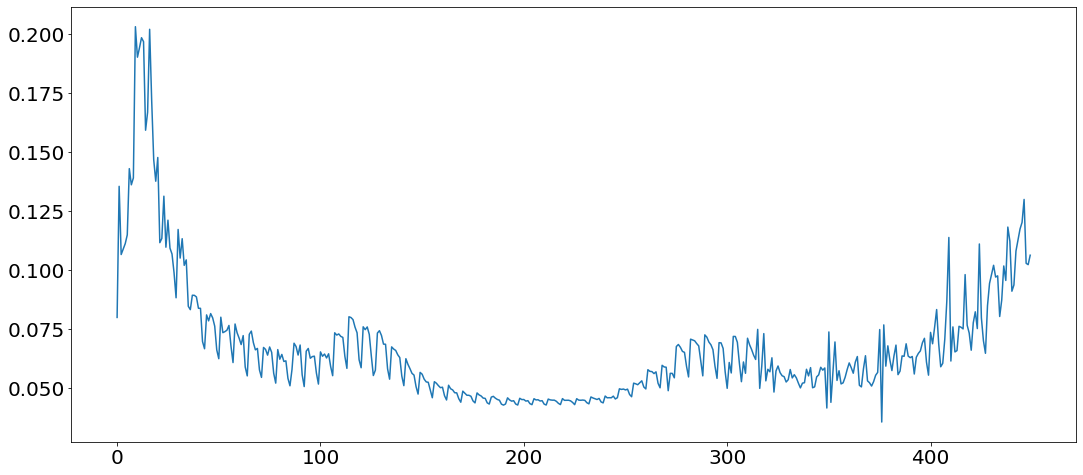

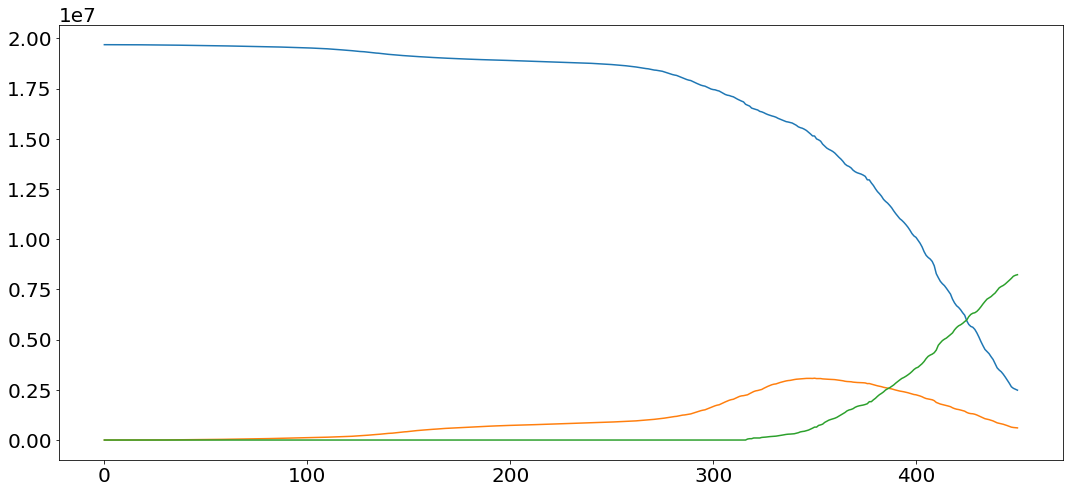

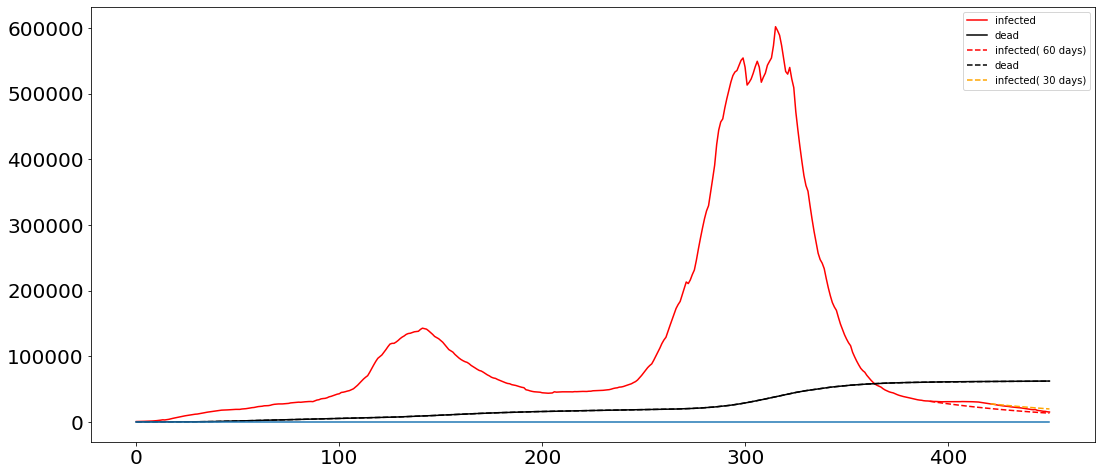

In [192]:
pathc="../Data/Vaccination Data/State Data With Vaccinations/"
# modify the path syntax based on the current platform

filename = "CA.csv"

dates, infectRaw, recovRaw, deadRaw, vaccRaw = loadData(pathc + filename)

pop = getPop("California")
numDays =  len(dates)
q = 0.5

vacc = vaccRaw[0:numDays] * q
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

recov = approxRecovered(infect,dead)
recovRaw = approxRecovered(infectRaw,deadRaw)
infectRaw = infectRaw - deadRaw - recovRaw


suscept = q * pop - infect

dates = dates.tolist()
vInd = dates.index('1/11/2021')
vDiff = np.diff(vaccRaw)
vDiff = vDiff.tolist()
vDiff.append(vDiff[-1])


for t in range(vInd, len(dates)): 
  
    subS = (vDiff[t] * suscept[t]) / (suscept[t] + recovRaw[t])
    subR = (vDiff[t] * recovRaw[t]) / (suscept[t] + recovRaw[t])
    
    for i in range(t,len(dates)):
        suscept[i] -= subS
        recovRaw[i] -= subR
    

dRate = getNu(infect, dead)
rRate = getGamma(suscept, infect, dead, vacc)
iRate = getBeta(suscept,infect, recov, vacc, rRate,dRate)
ig,ax = plt.subplots(figsize = (18,8))
ax.plot(iRate)

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(suscept)
ax.plot(recovRaw)
ax.plot(vacc)



infect = infect - recov - dead


params = np.zeros(((len(iRate)),3))
params[:,0] = np.array(iRate.tolist()).flatten()
params[:,1] = np.array(rRate.tolist() * len(iRate)).flatten()
params[:,2] = np.array(dRate.tolist() * len(iRate)).flatten()


daysToPredict = 60



predictMatch(suscept[:numDays], infectRaw[:numDays],  recovRaw[:numDays], deadRaw[:numDays], vaccRaw[:numDays], pop, daysToPredict, qVal=q, param = params)

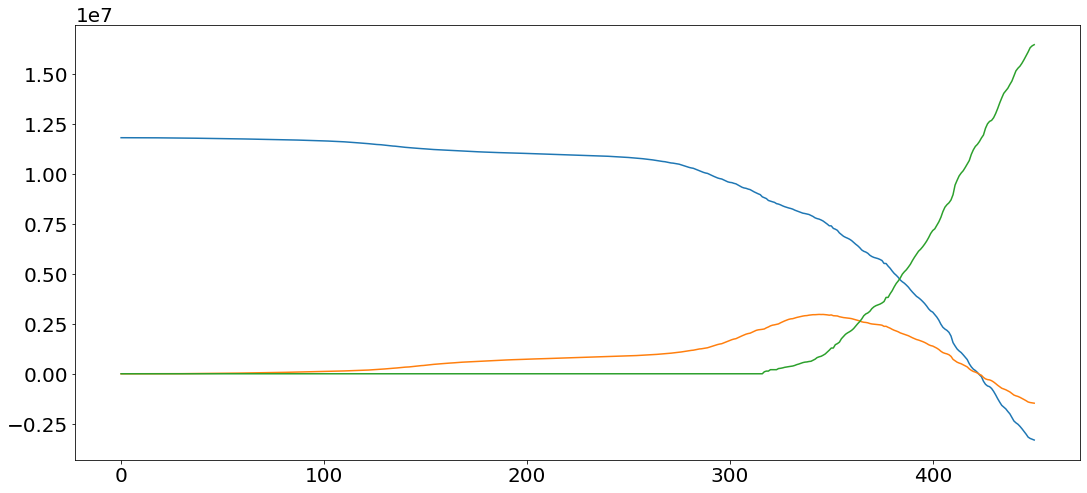

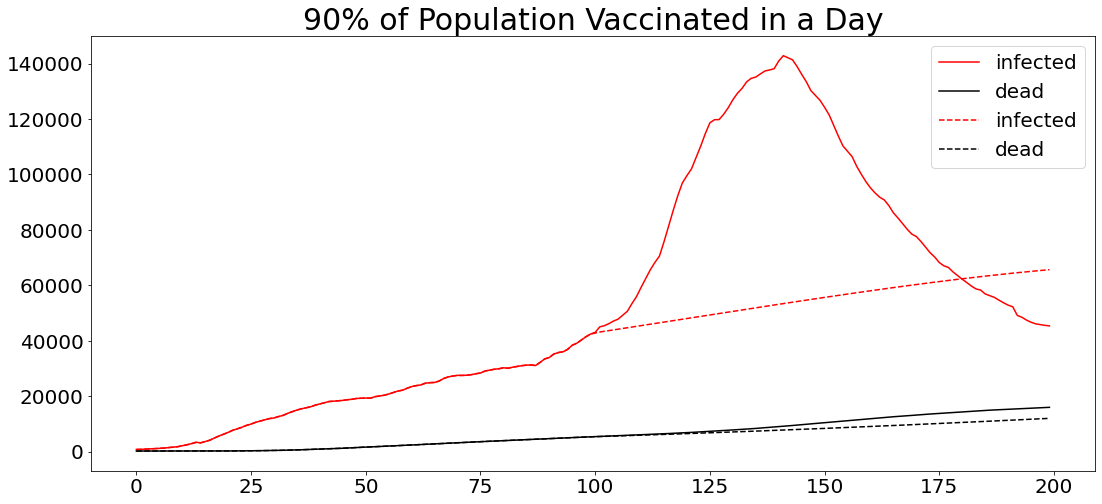

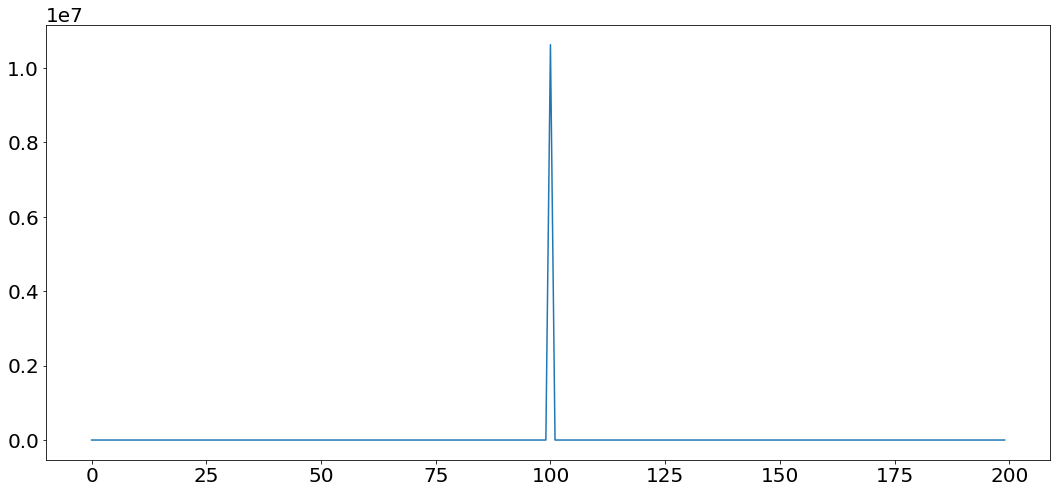

In [121]:
pathc="../Data/Vaccination Data/State Data With Vaccinations/"
# modify the path syntax based on the current platform

filename = "CA.csv"

dates, infectRaw, recovRaw, deadRaw, vaccRaw = loadData(pathc + filename)

pop = getPop("California")
numDays =  200
q = 0.3

vacc = vaccRaw[0:numDays] * q
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

recov = approxRecovered(infect,dead)
recovRaw = approxRecovered(infectRaw,deadRaw)



suscept = q * pop - infectRaw

infectRaw = infectRaw - deadRaw - recovRaw
dates = dates.tolist()
vInd = dates.index('1/11/2021')
vDiff = np.diff(vaccRaw)
vDiff = vDiff.tolist()
vDiff.append(vDiff[-1])



for t in range(vInd, len(dates)): 
  
    subS = (vDiff[t] * suscept[t]) / (suscept[t] + recovRaw[t])
    subR = (vDiff[t] * recovRaw[t]) / (suscept[t] + recovRaw[t])
    
    for i in range(t,len(dates)):
        suscept[i] -= subS
        recovRaw[i] -= subR
    

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(suscept)
ax.plot(recovRaw)
ax.plot(vaccRaw)


suscept = suscept[:numDays]
dRate = getNu(infect, dead)
rRate = getGamma(suscept, infect, dead, vacc)
infect = infect - recov - dead
iRate = getBeta(suscept,infect, recov, vacc, rRate,dRate)





params = np.zeros(((len(iRate)),3))
params[:,0] = np.array(iRate.tolist()).flatten()
params[:,1] = np.array(rRate.tolist() * len(iRate)).flatten()
params[:,2] = np.array(dRate.tolist() * len(iRate)).flatten()


daysToPredict = 100
infect = infectRaw[0:numDays-daysToPredict-14]
recov = recovRaw[0:numDays-daysToPredict-14]
dead = deadRaw[0:numDays-daysToPredict-14]


predictMatchVaccPulse(suscept[:numDays], infectRaw[:numDays],  recovRaw[:numDays], deadRaw[:numDays], vaccRaw[:numDays], pop, daysToPredict, qVal=q, param = params)